In [3]:
# Checking GPU
!nvidia-smi

Fri Apr 26 12:18:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-04-26 12:18:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.8MB/s    in 4.6s    

2024-04-26 12:18:25 (35.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
with zipfile.ZipFile('/content/10_food_classes_10_percent.zip') as zip_ref:
  zip_ref.extractall()

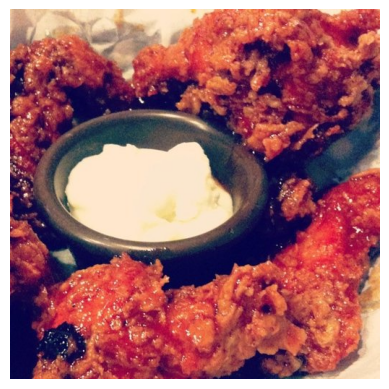

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/10_food_classes_10_percent/train/chicken_wings/1022742.jpg')
imgplot = plt.imshow(img)
plt.axis(False);

In [7]:
import os
for (dirpath, dirnames, filenames) in os.walk('/content/10_food_classes_10_percent'):
  print(f'There are {len(dirpath)} directories and {len(filenames)} images in {dirpath}')

There are 35 directories and 0 images in /content/10_food_classes_10_percent
There are 40 directories and 0 images in /content/10_food_classes_10_percent/test
There are 46 directories and 250 images in /content/10_food_classes_10_percent/test/sushi
There are 46 directories and 250 images in /content/10_food_classes_10_percent/test/steak
There are 51 directories and 250 images in /content/10_food_classes_10_percent/test/fried_rice
There are 46 directories and 250 images in /content/10_food_classes_10_percent/test/pizza
There are 55 directories and 250 images in /content/10_food_classes_10_percent/test/grilled_salmon
There are 50 directories and 250 images in /content/10_food_classes_10_percent/test/hamburger
There are 46 directories and 250 images in /content/10_food_classes_10_percent/test/ramen
There are 54 directories and 250 images in /content/10_food_classes_10_percent/test/chicken_wings
There are 50 directories and 250 images in /content/10_food_classes_10_percent/test/ice_cream
T

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_10_percent = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')
test_data_10_percent = test_datagen.flow_from_directory(directory = test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


<ipython-input-9-ad35ceb7f950>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, n)


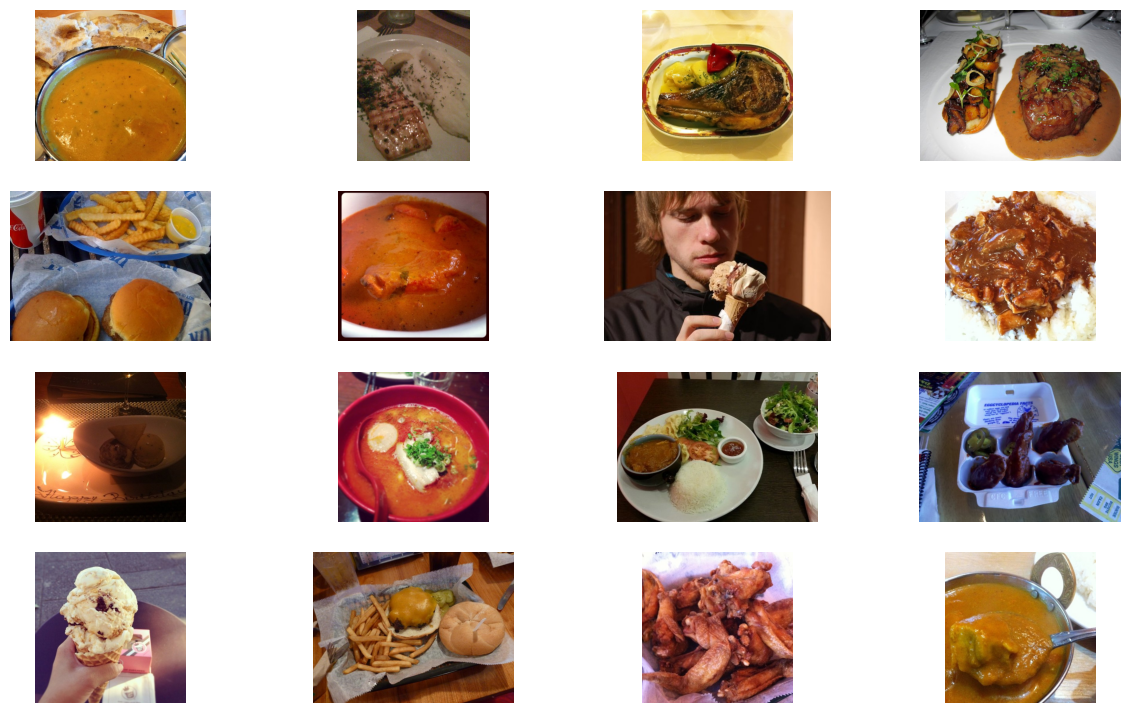

In [9]:
import random
from PIL import Image

images = []
for folder in os.listdir(train_dir):
  for image in os.listdir(train_dir + '/' + folder):
    images.append(os.path.join(train_dir, folder, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = mpimg.imread(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()

In [10]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientrel_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

In [12]:
IMAGE_SHAPE = (224, 224)

In [13]:
def create_model(model_url, num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'Feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3, ))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax', name = 'output_layer')
  ])

  return model

In [14]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [15]:
train_data_10_percent.num_classes

10

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [17]:
resnet_model.weights

[<tf.Variable 'resnet_v2_50/block2/unit_1/bottleneck_v2/shortcut/biases:0' shape=(512,) dtype=float32, numpy=
 array([ 4.31418499e-07,  4.89472598e-07,  2.27145790e-07, -8.81433607e-07,
        -4.73612602e-07, -5.08580285e-07,  2.22534609e-07, -2.61754479e-07,
        -5.20312483e-07,  5.15780016e-07,  6.28244322e-07, -1.23574966e-06,
        -2.06205897e-07, -5.50552784e-07,  4.59568270e-07,  1.22070418e-07,
         1.27279168e-06,  2.39852739e-07, -1.79164545e-06,  5.12351086e-08,
         2.51728920e-06,  7.22962625e-07,  1.10817304e-07, -1.69962846e-06,
        -3.23063404e-07, -9.74833142e-07,  1.12322664e-06,  4.19217031e-07,
         7.60933744e-07, -5.42234204e-07,  1.20253515e-06,  1.10281167e-06,
        -3.48003937e-07, -7.72205851e-07,  1.68280877e-07, -3.24905358e-07,
        -1.27801570e-06,  1.57823706e-06,  6.09036192e-07,  1.57570196e-06,
         1.42022566e-06,  7.20819116e-07,  5.48808785e-08,  4.61077349e-07,
         1.15990485e-06,  4.04862874e-07, -5.38943368e

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])

In [19]:
resnet_history = resnet_model.fit(train_data_10_percent,
                 batch_size=32,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=(test_data_10_percent),
                 validation_steps=len(test_data_10_percent))

Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.8678 - accuracy: 0.3627 - val_loss: 1.1914 - val_accuracy: 0.6368
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9043 - accuracy: 0.7200 - val_loss: 0.8611 - val_accuracy: 0.7228
Epoch 3/5
24/24 [==============================] - 14s 581ms/step - loss: 0.6241 - accuracy: 0.8293 - val_loss: 0.7530 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.4798 - accuracy: 0.8773 - val_loss: 0.6943 - val_accuracy: 0.7800
Epoch 5/5
24/24 [==============================] - 13s 547ms/step - loss: 0.3785 - accuracy: 0.9147 - val_loss: 0.6675 - val_accuracy: 0.7880


In [20]:
resnet_model.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 114ms/step - loss: 0.6675 - accuracy: 0.7880


[0.6674866080284119, 0.7879999876022339]

In [21]:
resnet_model.layers

In [22]:
resnet_model.layers[0]

In [23]:
import pandas as pd
import numpy as np


In [24]:
def plot_loss_curve(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  # Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

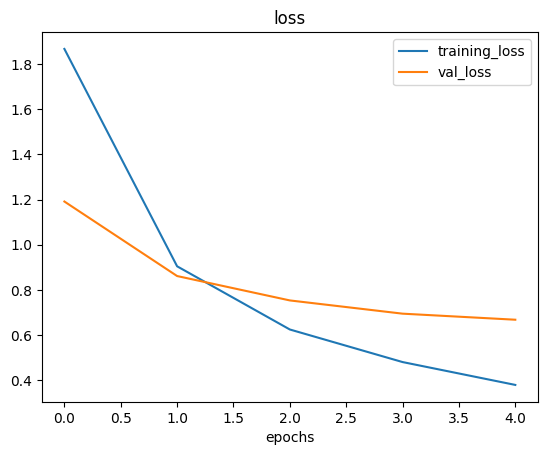

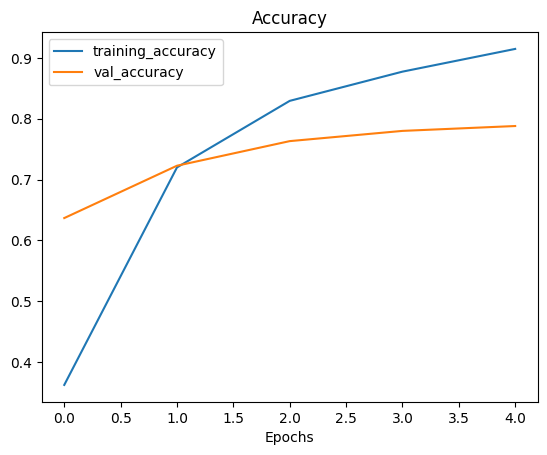

In [25]:
plot_loss_curve(resnet_history)

In [26]:
efficientrel_model = create_model(efficientrel_url,
                                  train_data_10_percent.num_classes)

In [27]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
efficientrel_model.compile(loss='categorical_crossentropy',
                           optimizer=optimizer,
                           metrics='accuracy')

In [28]:
efficientrel_history = efficientrel_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data_10_percent,
                       validation_steps=len(test_data_10_percent))

Epoch 1/5
24/24 [==============================] - 45s 1s/step - loss: 1.8649 - accuracy: 0.4040 - val_loss: 1.2764 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 15s 651ms/step - loss: 1.0604 - accuracy: 0.7693 - val_loss: 0.8510 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7564 - accuracy: 0.8373 - val_loss: 0.6859 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 11s 473ms/step - loss: 0.6084 - accuracy: 0.8573 - val_loss: 0.6018 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 11s 466ms/step - loss: 0.5146 - accuracy: 0.8760 - val_loss: 0.5513 - val_accuracy: 0.8624


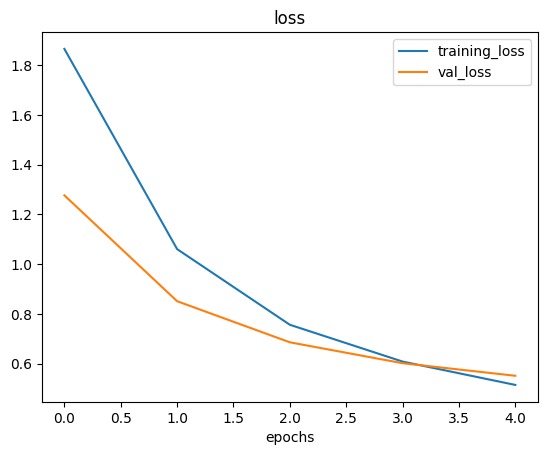

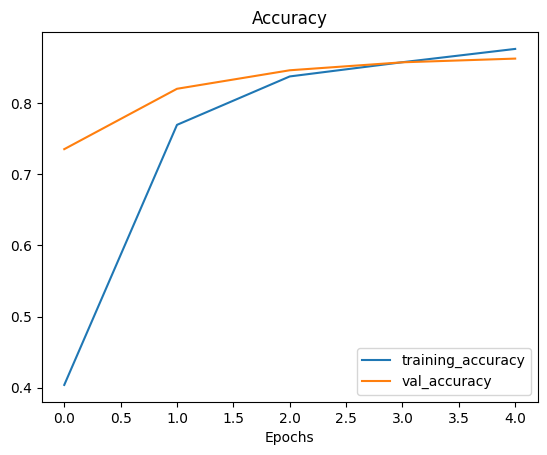

In [29]:
plot_loss_curve(efficientrel_history)

In [30]:
efficientrel_model.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 102ms/step - loss: 0.5513 - accuracy: 0.8624


[0.5513359308242798, 0.8623999953269958]

# 100% Data

In [31]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

import zipfile
zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

--2024-04-26 12:24:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 142.251.18.207, 142.250.153.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  40.1MB/s    in 13s     

2024-04-26 12:24:14 (37.8 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]

There are 2 directories and 0 images in 10_food_classes_all_data.
There are 10 directories and 0 images in 10_food_classes_all_data/test.
There are 0 directories and 250 images in 10_food_classes_all_data/test/sushi.
There are 0 directories and 250 images in 10_food_classes_all_data/test/steak.
There are 0 directories and 250 images in 10_food_classes_all_data/test

In [31]:
train_dir = '/content/10_food_classes_all_data/train'
test_dir = '/content/10_food_classes_all_data/test'

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_data_full = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,)
test_data_full = test_datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [34]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
efficientrel_model.compile(loss='categorical_crossentropy',
                           optimizer=optimizer,
                           metrics='accuracy')

In [35]:
efficientrel_history = efficientrel_model.fit(train_data_full,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_full),
                                              validation_data=test_data_full,
                                              validation_steps=len(test_data_full))

Epoch 1/5
24/24 [==============================] - 27s 1s/step - loss: 0.4556 - accuracy: 0.8893 - val_loss: 0.5055 - val_accuracy: 0.8624
Epoch 2/5
24/24 [==============================] - 10s 444ms/step - loss: 0.3704 - accuracy: 0.9227 - val_loss: 0.4669 - val_accuracy: 0.8676
Epoch 3/5
24/24 [==============================] - 10s 438ms/step - loss: 0.3156 - accuracy: 0.9373 - val_loss: 0.4428 - val_accuracy: 0.8748
Epoch 4/5
24/24 [==============================] - 12s 512ms/step - loss: 0.2736 - accuracy: 0.9520 - val_loss: 0.4280 - val_accuracy: 0.8756
Epoch 5/5
24/24 [==============================] - 11s 472ms/step - loss: 0.2391 - accuracy: 0.9640 - val_loss: 0.4146 - val_accuracy: 0.8768


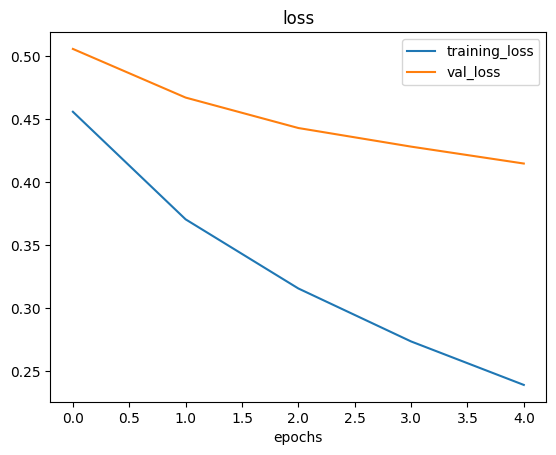

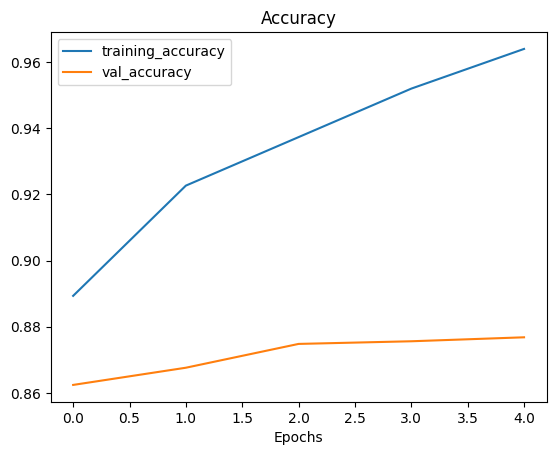

In [36]:
plot_loss_curve(efficientrel_history)

In [37]:
efficientrel_model.evaluate(test_data_full)

79/79 [==============================] - 9s 111ms/step - loss: 0.4146 - accuracy: 0.8768


[0.4146037995815277, 0.876800000667572]

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics='accuracy')

In [40]:
resnet_history = resnet_model.fit(train_data_full,
                                  epochs = 5,
                                  steps_per_epoch=len(train_data_full),
                                  validation_data = test_data_full,
                                  validation_steps = len(test_data_full))

Epoch 1/5
24/24 [==============================] - 27s 1s/step - loss: 0.3452 - accuracy: 0.9080 - val_loss: 0.6388 - val_accuracy: 0.7960
Epoch 2/5
24/24 [==============================] - 11s 463ms/step - loss: 0.2286 - accuracy: 0.9573 - val_loss: 0.6213 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 11s 489ms/step - loss: 0.1719 - accuracy: 0.9787 - val_loss: 0.6140 - val_accuracy: 0.7968
Epoch 4/5
24/24 [==============================] - 12s 507ms/step - loss: 0.1368 - accuracy: 0.9840 - val_loss: 0.6112 - val_accuracy: 0.7964
Epoch 5/5
24/24 [==============================] - 12s 508ms/step - loss: 0.1117 - accuracy: 0.9960 - val_loss: 0.6128 - val_accuracy: 0.8044


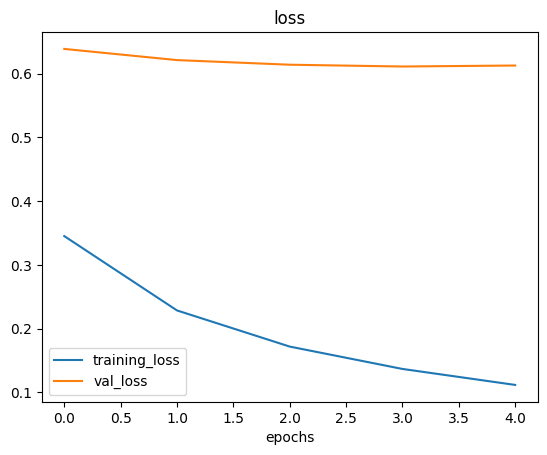

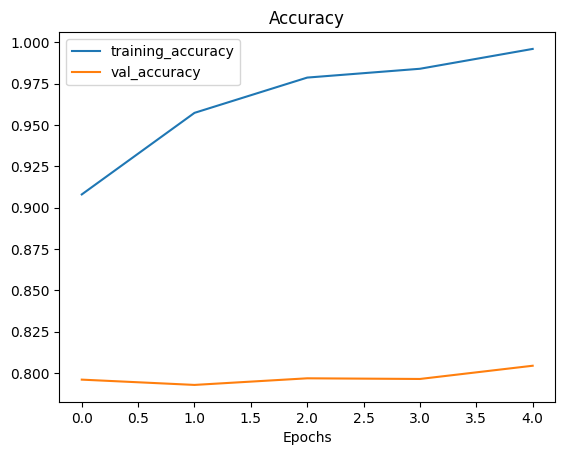

In [41]:
plot_loss_curve(resnet_history)

In [42]:
resnet_model.evaluate(test_data_full)

79/79 [==============================] - 9s 114ms/step - loss: 0.6128 - accuracy: 0.8044


[0.6127714514732361, 0.8044000267982483]